In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import copy

In [2]:
data = pd.read_csv( 'adult.csv' )
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
le = LabelEncoder()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Путем выкидывания некоторых значений, выяснилось, что "fnlwgt" является помехой, выкинем его.

In [5]:
data.drop('fnlwgt', axis = 1, inplace= True)

In [6]:
df = data.copy()
cat_feat = list(df.dtypes[df.dtypes == object].index)
for column in cat_feat:
    df = df[df[column] != '?']
df.shape

(45222, 14)

In [7]:
le.fit( df['income'] )
y = pd.Series(data = le.transform(df['income']))
df.drop('income', axis = 1, inplace= True)
cat_feat.remove('income')

In [8]:
le.transform(['<=50K', '>50K'])

array([0, 1], dtype=int64)

Целевые переменные: 0 - <=50K, 1 - >50K

In [9]:
num_feat = [f for f in df if f not in (cat_feat)]

Сделаем dummy - преобразование для категориальных фичей.
Так как есть много фичей с большим количеством уникальных значений, оставим только те, в которых значений не больше 10 (см. 4 строку)

In [10]:
cat_nunique = df[cat_feat].nunique()
num_feat = [f for f in df if f not in (cat_feat + ['ID', 'target'])]
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 10].index)

workclass          7
education         16
marital-status     7
occupation        14
relationship       6
race               5
gender             2
native-country    41
dtype: int64


In [11]:
dummy_train = pd.get_dummies(df[cat_feat], columns=cat_feat)


Составим окончательную выборку из dummy - фичей и непрерывных

In [12]:
X = pd.concat([df[num_feat],
                     dummy_train], axis=1)

In [13]:
X.head()

,age,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male
0,25,7,0,0,40,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1
1,38,9,0,0,50,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2,28,12,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,44,10,7688,0,40,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
5,34,6,0,0,30,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1


Применим случайный стритифицированный выбор элементов из выборки для составления train и test. Размер Тестовой - 20%.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

In [15]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in splitter.split(X, y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

In [16]:
logr = LogisticRegression()

Предсказание

In [17]:
logr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
y_pred = logr.predict_proba(X_test)


In [19]:
y_pred

array([[0.18352577, 0.81647423],
       [0.63810921, 0.36189079],
       [0.82060417, 0.17939583],
       ...,
       [0.97595744, 0.02404256],
       [0.18696866, 0.81303134],
       [0.41374927, 0.58625073]])

In [20]:
logr.score(X_test, y_test)

0.8446655610834716

In [21]:
x_class = df[ ['education', 'capital-gain', 'capital-loss'] ]
x_class = pd.get_dummies(x_class, columns = ['education'])

In [22]:
from sklearn.model_selection import train_test_split
X_train_cl, X_test_cl, Y_train_cl, Y_test_cl = train_test_split(x_class, y, test_size = 0.2)

In [23]:
logr_cl = LogisticRegression()

In [24]:
logr_cl.fit(X_train_cl, Y_train_cl)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
y_class_pred = logr_cl.predict_proba(X_test_cl)

In [26]:
logr_cl.score(X_test_cl, Y_test_cl)

0.8067440574903262

Построим кривую fpr-tpr и найдем площадь под кривой

In [27]:
from sklearn.metrics import auc, roc_curve

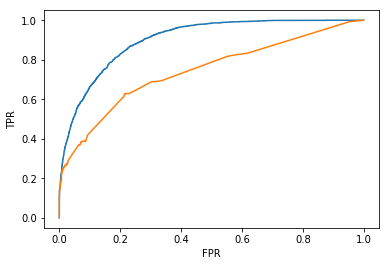

In [28]:
fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
fpr_cl, tpr_cl, a = roc_curve(Y_test_cl, y_class_pred[:,1])
auc_val = auc(fpr, tpr)
auc_val_cl = auc(fpr_cl, tpr_cl)
plt.plot(fpr, tpr)
plt.plot(fpr_cl, tpr_cl)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [29]:
auc_val, auc_val_cl

(0.9017278085978493, 0.7438572300301307)

Попробуем подобрать какой-нибудь параметр модели

In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
params = [ {'penalty': ['l1', 'l2'], 'C':[10, 1, 0.01]} ]

In [32]:
gs = GridSearchCV( LogisticRegression(), param_grid = params, cv = 5, scoring = 'roc_auc', return_train_score = False )

In [33]:
gs.fit( X, y )

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': [10, 1, 0.01]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=0)

In [34]:
gs.best_params_

{'C': 10, 'penalty': 'l1'}

In [35]:
logr_best = LogisticRegression(C=10, penalty = 'l1')

In [36]:
logr_best.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
y_pred_best = logr_best.predict_proba(X_test)

In [38]:
logr_best.score(X_test, y_test)

0.8454394693200663

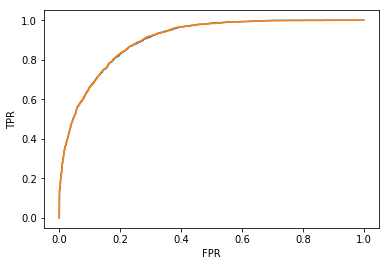

In [39]:
fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
fpr_best, tpr_best, b = roc_curve(y_test, y_pred_best[:,1])
auc_val = auc(fpr, tpr)
auc_val_best = auc(fpr_best, tpr_best)
plt.plot(fpr, tpr)
plt.plot(fpr_best, tpr_best)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [40]:
auc_val, auc_val_best

(0.9017278085978493, 0.9021087996676704)

Как-то так :)